# [Keras + Universal Sentence Encoder = Deep Meter] (https://www.dlology.com/blog/keras-meets-universal-sentence-encoder-transfer-learning-for-text-data/) 

This notebook creates an autoencoder using the Universal Sentence Encoder. The autoencoder output is CMUdict syllables. The dataset is that subset of Allison Parrish's Project Gutenberg poetry archive which happens to scan in iambic pentameter.

The notebook is based on Chengwei Zhang's example of wrapping the USE inside a larger tensorflow model saves to a Keras model (without save the USE itself in the TF model).

The Universal Sentence Encoder makes getting sentence level embeddings as easy as it has historically been to lookup the embeddings for individual words. The sentence embeddings can then be trivially used to compute sentence level meaning similarity as well as to enable better performance on downstream classification tasks using less supervised training data.

Since there are 10 one-hot values for 10 sets of 6k syllables, this is "multi-label classification"
Changes for multi-label classification:
sigmoid activation instead of softmax
binary_crossentropy

Text format is tab-separated, 2 columns: first text, second multi-level
array of syllables:

Multi-output version

# Getting Started

This section sets up the environment for access to the Universal Sentence Encoder on TF Hub and provides examples of applying the encoder to words, sentences, and paragraphs.

In [1]:
# Install the latest Tensorflow version.
!pip3 install --quiet "tensorflow>=1.7"
# Install TF-Hub.
!pip3 install --quiet tensorflow-hub
!pip3 install pygtrie
#%cd /content
!git clone https://github.com/LanceNorskog/deep_meter || true
%cd /content/deep_meter
!git pull
# could not figure out how to read gzipped files as text!
!gunzip -qf blobs/*.gz || true
!gunzip -qf prepped_data/*.gz || true

fatal: destination path 'deep_meter' already exists and is not an empty directory.
/content/deep_meter
Already up to date.
gzip: blobs/*.gz: No such file or directory
gzip: prepped_data/*.gz: No such file or directory


In [2]:
# boilerplate from base notebook
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import keras.layers as layers
from keras.models import Model
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Nadam, Adam
import gc
from google.colab import files
from google.colab import drive

import pickle
np.random.seed(10)

Using TensorFlow backend.


In [0]:
# github deep_meter code
import utils
# should not need this to use utils.flatten but is true anyway?
from itertools import chain, product
import subprocess
import syllables
import decodesyllables
import cmudict
# misc for this notebook
from ast import literal_eval

import scipy



In [4]:
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]

In [0]:
# read classified poetry lines: text tab [['syll', 'la', 'ble'], ...]
# clip to only most common syllables with syllable manager
# ['words', ...], [[[0,0,1,0], ...]]
def get_data(filename, syll_mgr, num_symbols, max_lines=45000):
    num_syllables = syll_mgr.get_size()      
    lines = open(filename, 'r').read().splitlines()
    num_lines = min(max_lines, len(lines))
    text_lines = []
    text_sylls = []
    for i in range(0, len(lines)):
      if i == num_lines:
        break
      parts = lines[i].split("\t")
      label = utils.flatten(literal_eval(parts[1]))
      if len(label) == num_symbols:
        text_lines.append(str(parts[0]))
        text_sylls.append(label)
    num_lines = len(text_lines)
    label_array = np.zeros((num_symbols, num_lines, num_syllables), dtype=np.int8)
    for i in range(0, num_lines):
      for j in range(num_symbols):
        label_array[j][i][syll_mgr.get_encoding(text_sylls[i][j])] = 1

    return (text_lines, label_array)


In [0]:
# syllables in descending order of occurrence - 6k in gutenberg.iambic_pentameter, 15k total
# clamp to most common 100 syllables while debugging- use NCE to get all syllables or interesting number
# 98 + pause + wildcard
# iambic pentameter
num_symbols = 10
#syll_mgr = syllables.syllables(num_syllables)
syll_mgr = syllables.syllables()
num_syllables = syll_mgr.get_size() 
syll_weights = {}
counts = syll_mgr.get_counts()
maxim = np.max(counts)
for i in range(len(counts)):
  if counts[i] > 0:
    syll_weights[i] = 1/(counts[i]/maxim)
  else:
    syll_weights[i] = 0



In [8]:
(train_text, train_label) = get_data('prepped_data/gutenberg.iambic_pentameter.train', syll_mgr, num_symbols)
num_training = len(train_text)
#train_text = train_text[0:100]
#train_label = train_label[0:100]

(test_text, test_label) = get_data('prepped_data/gutenberg.iambic_pentameter.test', syll_mgr, num_symbols)
#test_text = test_text[0:100]
#test_label = test_label[0:100]

num_testing = len(test_text)
print(len(train_text))
print(len(test_text))
print(train_label.shape)
print(test_label.shape)

42234
4200
(10, 42234, 6635)
(10, 4200, 6635)


## Embed training & test text

In [9]:
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)
# important?
embed_size = embed.get_output_info_dict()['default'].get_shape()[1].value

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)
print(type(train_text))
#train_text_t = tf.convert_to_tensor(train_text, dtype='string', name='training_text')
with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  train_embeddings = session.run(embed(train_text))
  test_embeddings = session.run(embed(test_text))
train_text_d = np.array(train_embeddings)
test_text_d = np.array(test_embeddings)
print(train_text_d.shape)
print(test_text_d.shape)
# conserve space
embed = None
train_text = None
train_embeddings = None

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
<class 'list'>
(42234, 512)
(4200, 512)


In [12]:
print(test_text_d.shape)
# slow
num_epochs = 40
adam_0001 = Adam(0.0007)
adam_0001 = tf.contrib.opt.AdamWOptimizer(0.0007)
adam_0001 = Adam(0.0005)
adam_0001 = tf.contrib.opt.NadamOptimizer(0.0005)



(4200, 512)


## Assemble model

In [13]:
input_embeddings = layers.Input(shape=(512,), dtype=tf.float32, name='Input')
dropout_input = layers.Dropout(0.4)(input_embeddings)
dense = layers.Dense(1024, activation='relu', name='Convoluted')(dropout_input)
dense = layers.Dropout(0.4)(input_embeddings)
dense = layers.Dense(1536, activation='relu', name='Midway')(dense)
dense = layers.Dropout(0.4)(input_embeddings)
dense = layers.Dense(2048, activation='relu', name='Smooth')(dense)
pred_array = []
loss_array = []
names_array = []
for i in range(num_symbols):
  name = 'Flatout'+str(i)
  pred_array.append(layers.Dense(num_syllables, activation='softmax', name=name)(dense))
  loss_array.append('categorical_crossentropy')
  names_array.append(name)
model = Model(inputs=input_embeddings, outputs=pred_array)
model.compile(loss=loss_array, 
              optimizer=adam_0001, 
              metrics=['categorical_accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 512)          0                                            
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 512)          0           Input[0][0]                      
__________________________________________________________________________________________________
Smooth (Dense)                  (None, 2048)         1050624     dropout_6[0][0]                  
__________________________________________________________________________________________________
Flatout0 (Dense)                (None, 6635)         13595115    Smooth[0][0]                     
__________________________________________________________________________________________________
Flatout1 (

## Train Keras model and save weights
This only trains and save our Keras layers not the embed module' weights.

In [0]:
use_saved_model=False
history = None
print(train_label.shape)
if not use_saved_model or not os.path.exists('./model_syllables.h5'):
  with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    train_labels = []
    test_labels = []
    for i in range(num_symbols):
        train_labels.append(np.array(train_label[i]))
        test_labels.append(np.array(test_label[i]))
    history = model.fit(train_text_d, 
            train_labels,
            validation_data=(test_text_d, test_labels),
            epochs=num_epochs,
            #callbacks = [EarlyStopping(patience=2)],
            batch_size=64,
            class_weight=syll_weights,
            verbose=2
            )
    model.save_weights('./model_syllables.h5')


(10, 42234, 6635)
Train on 42234 samples, validate on 4200 samples
Epoch 1/40
 - 93s - loss: 57.9946 - Flatout0_loss: 2.5754 - Flatout1_loss: 7.2093 - Flatout2_loss: 4.9106 - Flatout3_loss: 7.2455 - Flatout4_loss: 5.1078 - Flatout5_loss: 6.9686 - Flatout6_loss: 4.8319 - Flatout7_loss: 7.0609 - Flatout8_loss: 4.8935 - Flatout9_loss: 7.1910 - Flatout0_categorical_accuracy: 0.4230 - Flatout1_categorical_accuracy: 0.0236 - Flatout2_categorical_accuracy: 0.1553 - Flatout3_categorical_accuracy: 0.0211 - Flatout4_categorical_accuracy: 0.1268 - Flatout5_categorical_accuracy: 0.0475 - Flatout6_categorical_accuracy: 0.1750 - Flatout7_categorical_accuracy: 0.0366 - Flatout8_categorical_accuracy: 0.1388 - Flatout9_categorical_accuracy: 0.0238 - val_loss: 54.1041 - val_Flatout0_loss: 1.9605 - val_Flatout1_loss: 6.7318 - val_Flatout2_loss: 4.5675 - val_Flatout3_loss: 6.8630 - val_Flatout4_loss: 4.7929 - val_Flatout5_loss: 6.6584 - val_Flatout6_loss: 4.5403 - val_Flatout7_loss: 6.7785 - val_Flatout8_

In [25]:
!mv model_syllables2.h5 model_syllables.h5
!ls -alh | grep model_syllables.h5
#!ls /content/gdrive/'My Drive'/'Colab Notebooks'

!cp model_syllables.h5 /content/gdrive/My\ Drive/Colab\ Notebooks/model_syllables.h5

-rw-r--r-- 1 root root 523M Nov  8 20:47 model_syllables.h5


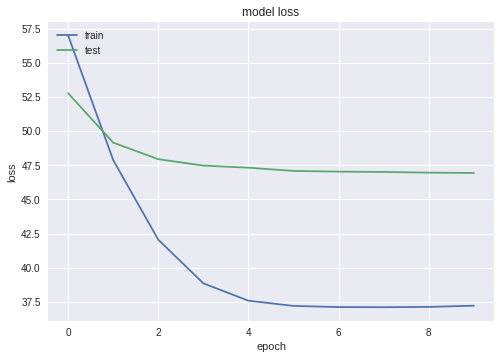

In [14]:
if history != None:
  # summarize history for accuracy
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

val_loss
<class 'list'>
10
<class 'numpy.float64'>


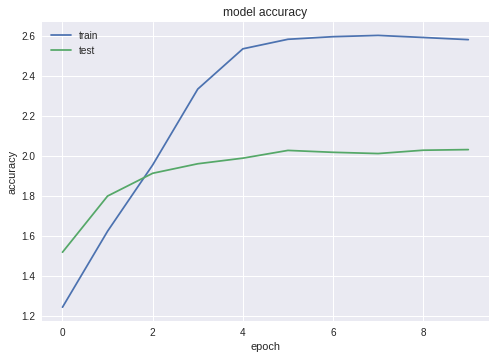

In [24]:
num_tests = 10
if history != None:
  for key in history.history.keys():
    print(key)
    print(type(history.history[key]))
    print(len(history.history[key]))
    print(type(history.history[key][0]))
    break
  acc = [1.0]*num_tests
  val_acc = [1.0]*num_tests
  for i in range(num_tests):
    sum = 0.0
    val_sum = 0.0
    count = 0
    for key in history.history.keys():
      vals = history.history[key]
      if key.endswith('categorical_accuracy') and not key.startswith('val_'):
        sum += vals[i]
      if key.endswith('categorical_accuracy') and key.startswith('val_'):
        val_sum += vals[i]
    acc[i] = sum
    val_acc[i] = val_sum
    
  history.history['val_acc'] = val_acc
  history.history['acc'] = acc
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [16]:
junk don't run

SyntaxError: ignored

In [0]:

os.remove('./model_syllables.h5')

In [0]:
os.remove('./predictions_syllables.pkl')